## Volatility Forecasts (Part 1 - STES Model)

This notebook corresponds to the first post in blog series [Volatility Forecasts (Part 1 - STES Model)](https://steveya.github.io/2024/07/12/volatility-forecast-1.html). The aim is to replicate the STES model as in [(Taylor, 2004)](https://doi.org/10.1016/j.ijforecast.2003.09.010) and [(Liu, Taylor, Choo 2020)](https://doi.org/10.1016/j.econmod.2020.02.021).

In [1]:
import numpy as np
import pandas as pd
from functools import partial
from scipy.optimize import minimize, least_squares
from scipy.special import expit
from matplotlib import pyplot as plt
from operator import itemgetter
import yfinance as yf
import xgboost as xgb
import random

The code in this section will reproduce Table 1 and Table 2 of the blog post, which implements the Smooth Transition Exponential Smoothing (STES) model in [(Taylor, 2004)](https://doi.org/10.1016/j.ijforecast.2003.09.010) and further analyzed in [(Liu, Taylor, Choo 2020)](https://doi.org/10.1016/j.econmod.2020.02.021)

The `simulated_contaminated_garch` function implements the simulation used in Liu et al. The rest of this section implements STES on different feature sets and follows the convention used in (Taylor 2004).

In [2]:
def simulate_contaminated_garch(n, mu, omega, alpha, beta, eta):
    returns = np.zeros(n)
    sigma2s = np.zeros(n)
    shocks = (np.random.uniform(0, 1, n) < 0.005).astype(float)
    for t in range(1, n):
        sigma2s[t] = omega + alpha * returns[t-1]**2 + beta * sigma2s[t-1]
        returns[t] = np.random.normal(mu, np.sqrt(sigma2s[t])) + eta * shocks[t]

    return returns, sigma2s

In [3]:
def stes_template(params, returns, features_func):
    """
    This function generates the variance forecasts and the 
    alphas for each time step using the STES model.

    Parameters
    ----------
    params : numpy.ndarray
        The parameters of the STES model.
    returns : numpy.ndarray
        The returns of the time series.
    features_func : list
        A list of functions that extract features from the returns.

    Returns
    -------
    sigma2s : numpy.ndarray
        The variance forecasts.
    alphas : numpy.ndarray
        The alphas for each time step.
    """
    assert len(params) == len(features_func)
    n = len(returns)
    sigma2s = np.zeros(n)
    alphas = np.zeros(n)
    for t in range(1, n):
        features = np.array([f(returns[t-1]) for f in features_func])
        alpha = expit(params @ features)
        alphas[t-1] = alpha
        sigma2s[t] = (1 - alphas[t-1]) * sigma2s[t-1] + alphas[t-1] * returns[t-1]**2

    return sigma2s, alphas


In [4]:
# feature functions used in the `feature_func` argument of `stes_template``
const = lambda _: 1
abs_x = np.abs
sqr_x = lambda x: x**2
id_x = lambda x: x

We use the above `stes_template` function to define the set of STES models used in (Taylor, 2004).

In [5]:
# building all the STES models (with ES being a special case)
es = partial(stes_template, features_func=(const,)) 
stes_ae = partial(stes_template, features_func=(const, abs_x))
stes_se = partial(stes_template, features_func=(const, sqr_x))
stes_eae = partial(stes_template, features_func=(const, abs_x, id_x))
stes_ese = partial(stes_template, features_func=(const, sqr_x, id_x))
stes_aese = partial(stes_template, features_func=(const, abs_x, sqr_x))
stes_eaese = partial(stes_template, features_func=(const, id_x, abs_x, sqr_x))

We also define loss of each observation as the squared of the forecasting error. We also define two metrics that help us compute root mean squared error (`rmse_metric`) and negative log-likelihood (`nllh_metric`).

In [6]:
def squared_residual(params, model, returns, is_index=500, os_index=2000):
    sigma2s, _ = model(params, returns)
    sse = (returns ** 2 - sigma2s)
    residual = sse[is_index:os_index]
    return residual

def rmse_metric(model, params, returns, is_index=500, os_index=2000):
    sigma2s, alphas = model(params, returns)
    
    sse = (returns ** 2 - sigma2s) ** 2
    is_rmse = np.sqrt(np.mean(sse[is_index:os_index]))
    os_rmse = np.sqrt(np.mean(sse[os_index:]))
    return is_rmse, os_rmse, sigma2s, alphas

def nllh_metric(model, params, returns, is_index=500, os_index=2000):
    sigma2s, alphas = model(params, returns)
   
    llh = -np.log(sigma2s[2:]) - (returns[2:] ** 2 / sigma2s[2:])
    is_nllh = -np.sum(llh[is_index:os_index])
    os_nllh = -np.sum(llh[os_index:])
    return is_nllh, os_nllh, sigma2s, alphas

I tested two ways to optimize the parameters of the general stes model. The first is to directly compute the root mean squared error (RMSE) from `rmse_metric` function, take the first output `is_rmse`, and use  `scipy.optimize.minimize` to find the optimal parameters. The second is to compute the residuals from `squared_residual` and then use `scipy.optimize.least_squares` to find the optimal parameters. I initialize the initial parameters to the optimizer using random draws from a standard gaussian distribution. 

I found that the second method is more robust to parameters initialization. Below are the expeiment fitting the `stes_ae` model using the two approaches with 10 random initialization.

In [15]:
def fit_model_minimize(model, param_dim, returns, is_index=500, os_index=2000):
    initial_params = np.random.normal(0, 1, size=param_dim)
    obj_func_inner = lambda *args, **kwargs: itemgetter(0)(partial(rmse_metric, model)(*args, **kwargs))
    result = minimize(obj_func_inner, initial_params, args=(returns, is_index, os_index), method = 'SLSQP')
    
    if not result.success:
        raise ValueError("Optimization failed: " + result.message)
    
    is_mse, os_mse, sigmas, alphas = rmse_metric(model,result.x, returns, is_index, os_index)
    is_llh, os_llh, _, _ = nllh_metric(model, result.x, returns, is_index, os_index)
    return (result.x, os_mse, os_llh, sigmas, alphas, is_mse, is_llh)

def fit_model_least_square(model, param_dim, returns, is_index=500, os_index=2000):
    initial_params = np.random.normal(0, 1, size=param_dim)
    obj_func_inner = partial(squared_residual, model=model, returns=returns, is_index=is_index, os_index=os_index)
    result = least_squares(obj_func_inner, initial_params)
    
    if not result.success:
        raise ValueError("Optimization failed: " + result.message)
    
    is_mse, os_mse, sigmas, alphas = rmse_metric(model,result.x, returns, is_index, os_index)
    is_llh, os_llh, _, _ = nllh_metric(model, result.x, returns, is_index, os_index)
    return (result.x, os_mse, os_llh, sigmas, alphas, is_mse, is_llh)

fit_es_minimize = partial(fit_model_minimize, model=es, param_dim=1)
fit_stes_ae_minimize = partial(fit_model_minimize, model=stes_ae, param_dim=2)
fit_stes_se_minimize = partial(fit_model_minimize, model=stes_se, param_dim=2)
fit_stes_eae_minimize = partial(fit_model_minimize, model=stes_eae, param_dim=3)
fit_stes_ese_minimize = partial(fit_model_minimize, model=stes_ese, param_dim=3)
fit_stes_aese_minimize = partial(fit_model_minimize, model=stes_aese, param_dim=3)

fit_es_least_square = partial(fit_model_least_square, model=es, param_dim=1)
fit_stes_ae_least_square = partial(fit_model_least_square, model=stes_ae, param_dim=2)
fit_stes_se_least_square = partial(fit_model_least_square, model=stes_se, param_dim=2)
fit_stes_ese_least_square = partial(fit_model_least_square, model=stes_ese, param_dim=3)
fit_stes_eae_least_square = partial(fit_model_least_square, model=stes_eae, param_dim=3)
fit_stes_aese_least_square = partial(fit_model_least_square, model=stes_aese, param_dim=3)
fit_stes_eaese_least_square = partial(fit_model_least_square, model=stes_eaese, param_dim=4)



To demonstrate that the `least_squares` optimizer works better in this case, we fit the same STES model with the same random initialization to a fixed return time series, and assess the stability of the fitted parameters.

In [12]:
np.random.seed(0)
np.random.seed(np.random.randint(0, 1e4, size=1))
simulated_garch_return, simulated_garch_var = simulate_contaminated_garch(
    n=2500, mu=0, omega=0.02, alpha=0.11, beta=0.87, eta=4
)

In [13]:
simulated_garch_return

array([ 0.        ,  0.18777651,  0.50878377, ..., -1.31751527,
        5.95541061, -5.28980025])

In [14]:
np.random.seed(0)
for _ in range(10):
    lss = least_squares(
        partial(
            squared_residual, 
            model=stes_ae, 
            returns=simulated_garch_return
        ), x0=np.random.normal(0, 1, 2)) 
    print(lss.x)

[-2.1670995  -0.11246057]
[-2.16702008 -0.11246866]
[-2.16714041 -0.11245641]
[-2.16711731 -0.11245876]
[-2.16701855 -0.11246882]
[-2.16712513 -0.11245797]
[-2.16697288 -0.11247378]
[-2.16716552 -0.11245386]
[-2.16707807 -0.11246275]
[-2.16712244 -0.11245824]


In [12]:
np.random.seed(0)
for _ in range(10):
    p, _, _, _, _, _, _ = fit_stes_ae_minimize(
        returns=simulated_garch_return
    )
    print(p)

[-2.16674593 -0.11249054]
[-11.80986301 -16.08684575]
[-2.1676799  -0.11233752]
[-2.1670345  -0.11249873]
[-2.16680262 -0.11192826]
[-2.16696151 -0.11245809]
[-2.1671567  -0.11248048]
[-2.16675334 -0.11247579]
[-2.16611258 -0.11210408]
[-2.16630593 -0.11304955]


Given exact same simualted sequence and random seeds used to gnerate the initial values to the optimizer, the `fit_stest_ae_minimize` function unstable optimas. After some playing around, the `fit_stest_ae_leastsquares` function seems to converge to a stable solution in repeated random runs.

Perhaps the `fit_stest_ae_minimize` function can (and should) be further tuned, but the `fit_stest_ae_leastsquares` function seems to converge to a stable solution in repeated random runs without any tuning.

#### STES and ES Performance on Simulated Contaminated GARCH Data
I simulate the contaminated GARCH time series using the same parameters as in the Taylor (2020) paper. I then fit the STES and ES models to the simulated data and measure their performance on the test sample 1-step ahead root mean square forecast error. The results are shown in Table 1.

In [111]:
stes_ae_os_rmses = []
stes_se_os_rmses = []
es_os_rmses = []

num_runs = 1000
np.random.seed(0)
rand_seeds = np.random.randint(0, 1e6, size=num_runs)
for i in range(num_runs):
    np.random.seed(rand_seeds[i])
    simulated_garch_return, simulated_garch_var = simulate_contaminated_garch(n=2500, mu=0, omega=0.02, alpha=0.11, beta=0.87, eta=4)
    _, os_stes_se_rmse, _, _, _, _, _ = fit_stes_se_least_square(returns=simulated_garch_return)
    _, os_stes_ae_rmse, _, _, _, _, _ = fit_stes_ae_least_square(returns=simulated_garch_return)
    _,      os_es_rmse,      _, _, _, _, _ = fit_es_least_square(returns=simulated_garch_return)
    stes_ae_os_rmses.append(os_stes_ae_rmse)
    stes_se_os_rmses.append(os_stes_se_rmse)
    es_os_rmses.append(os_es_rmse)


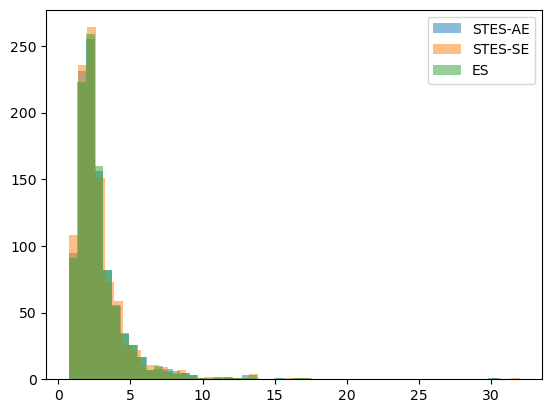

The mean of RMSE of the STES-AE model is 2.8452412258472464
The mean of RMSE of the STES-SE model is 2.8787248873818627
The mean of RMSE of the ES model is 2.85216396301645


In [112]:
plt.hist(stes_ae_os_rmses, bins=50, alpha=0.5, label='STES-AE')
plt.hist(stes_se_os_rmses, bins=50, alpha=0.5, label='STES-SE')
plt.hist(es_os_rmses, bins=50, alpha=0.5, label='ES')

plt.legend()
plt.show()

print(f"The mean of RMSE of the STES-AE model is {np.mean(stes_ae_os_rmses)}")
print(f"The mean of RMSE of the STES-SE model is {np.mean(stes_se_os_rmses)}")
print(f"The mean of RMSE of the ES model is {np.mean(es_os_rmses)}")


#### STES and ES on SPY Data
I take the data from 2000 and fit the first 4000 data points (this part deviate from Taylor (2020), where they fit to data up to 2010.) Our test-sample starts from 2015-11-27.

The RMSE reported is the average RMST of 100 different random initialization.

In [17]:
spy_adj_close = yf.download("SPY", start="2000-01-01", end="2023-12-31")
spy_log_returns = np.log(spy_adj_close["Adj Close"]).diff().dropna() * 100

[*********************100%%**********************]  1 of 1 completed


In [ ]:
print(f"SPY daily returns series has length {len(spy_log_returns)}")
print(f"Test data starts from {spy_log_returns.index[4000]}")

SPY daily returns series has length 6036
Test data starts from 2015-11-27 00:00:00


In [313]:
np.random.seed(0)
stes_eaese_spy_res = [fit_stes_eaese_least_square(returns=spy_log_returns.to_numpy(), is_index=200, os_index=4000) for _ in range(100)]

In [314]:
np.random.seed(0)
stes_aese_spy_res = [fit_stes_aese_least_square(returns=spy_log_returns.to_numpy(), is_index=200, os_index=4000) for _ in range(100)]

In [ ]:
np.random.seed(0)
stes_eae_spy_res = [fit_stes_eae_least_square(returns=spy_log_returns.to_numpy(), is_index=200, os_index=4000) for _ in range(100)]

In [ ]:
np.random.seed(0)
stes_ese_spy_res = [fit_stes_ese_least_square(returns=spy_log_returns.to_numpy(), is_index=200, os_index=4000) for _ in range(100)]

In [ ]:
np.random.seed(0)
es_spy_res = [fit_es_least_square(returns=spy_log_returns.to_numpy(), is_index=200, os_index=4000) for _ in range(100)]

In [315]:
print(f"""
      STES E&AE&SE Parameter Estimated on SPY Returns using MLE: {np.mean([s[0] for s in stes_eaese_spy_res], axis=0)},  
      Out-of-Sample Mean Squared Error = {np.mean([s[1] for s in stes_eaese_spy_res]):.6f}, 
      Out-of-Sample Neg Log-Likelihood = {np.mean([s[2] for s in stes_eaese_spy_res]):.6f}, 
      In-Sample Mean Squared Error = {np.mean([s[5] for s in stes_eaese_spy_res]):.6f},
      In-Sample Neg Log-Likelihood = {np.mean([s[6] for s in stes_eaese_spy_res]):.6f},
""")


      STES E&AE&SE Parameter Estimated on SPY Returns using MLE: [-2.13971751 -0.1875335   0.19358432 -0.04260397],  
      Out-of-Sample Mean Squared Error = 4.482820, 
      Out-of-Sample Neg Log-Likelihood = 1675.407590, 
      In-Sample Mean Squared Error = 4.982193,
      In-Sample Neg Log-Likelihood = 3810.830719,



In [ ]:
print(f"""
      STES AE&SE Parameter Estimated on SPY Returns using MLE: {np.mean([s[0] for s in stes_aese_spy_res], axis=0)},  
      Out-of-Sample Mean Squared Error = {np.mean([s[1] for s in stes_aese_spy_res]):.6f}, 
      Out-of-Sample Neg Log-Likelihood = {np.mean([s[2] for s in stes_aese_spy_res]):.6f}, 
      In-Sample Mean Squared Error = {np.mean([s[5] for s in stes_aese_spy_res]):.6f},
      In-Sample Neg Log-Likelihood = {np.mean([s[6] for s in stes_aese_spy_res]):.6f},
""")


      STES AE&SE Parameter Estimated on SPY Returns using MLE: [-1.99369875  0.14583494 -0.01878969],  
      Out-of-Sample Mean Squared Error = 4.489537, 
      Out-of-Sample Neg Log-Likelihood = 1694.970797, 
      In-Sample Mean Squared Error = 5.015911,
      In-Sample Neg Log-Likelihood = 3881.140969,



In [ ]:
print(f"""
      STES E&AE Parameter Estimated on SPY Returns using MLE: {np.mean([s[0] for s in stes_eae_spy_res], axis=0)},  
      Out-of-Sample Mean Squared Error = {np.mean([s[1] for s in stes_eae_spy_res]):.6f}, 
      Out-of-Sample Neg Log-Likelihood = {np.mean([s[2] for s in stes_eae_spy_res]):.6f}, 
      In-Sample Mean Squared Error = {np.mean([s[5] for s in stes_eae_spy_res]):.6f},
      In-Sample Neg Log-Likelihood = {np.mean([s[6] for s in stes_eae_spy_res]):.6f},
""")


      STES E&AE Parameter Estimated on SPY Returns using MLE: [-1.74420506 -0.0881549  -0.07851254],  
      Out-of-Sample Mean Squared Error = 4.518936, 
      Out-of-Sample Neg Log-Likelihood = 1758.061537, 
      In-Sample Mean Squared Error = 5.010678,
      In-Sample Neg Log-Likelihood = 3967.358026,



In [ ]:
print(f"""
      STES E&SE Parameter Estimated on SPY Returns using MLE: {np.mean([s[0] for s in stes_ese_spy_res], axis=0)},  
      Out-of-Sample Mean Squared Error = {np.mean([s[1] for s in stes_ese_spy_res]):.6f}, 
      Out-of-Sample Neg Log-Likelihood = {np.mean([s[2] for s in stes_ese_spy_res]):.6f}, 
      In-Sample Mean Squared Error = {np.mean([s[5] for s in stes_ese_spy_res]):.6f},
      In-Sample Neg Log-Likelihood = {np.mean([s[6] for s in stes_ese_spy_res]):.6f},
""")


      STES E&SE Parameter Estimated on SPY Returns using MLE: [-1.9648798  -0.03371338 -0.28462538],  
      Out-of-Sample Mean Squared Error = 4.495169, 
      Out-of-Sample Neg Log-Likelihood = 1715.324391, 
      In-Sample Mean Squared Error = 4.987671,
      In-Sample Neg Log-Likelihood = 3849.004265,



In [ ]:
print(f"""
      ES Parameter Estimated on SPY Returns using MLE: {np.mean([s[0] for s in es_spy_res], axis=0)},  
      Out-of-Sample Mean Squared Error = {np.mean([s[1] for s in es_spy_res]):.6f}, 
      Out-of-Sample Neg Log-Likelihood = {np.mean([s[2] for s in es_spy_res]):.6f}, 
      In-Sample Mean Squared Error = {np.mean([s[5] for s in es_spy_res]):.6f},
      In-Sample Neg Log-Likelihood = {np.mean([s[6] for s in es_spy_res]):.6f},
""")


      ES Parameter Estimated on SPY Returns using MLE: [-2.18338667],  
      Out-of-Sample Mean Squared Error = 4.637673, 
      Out-of-Sample Neg Log-Likelihood = 1696.482945, 
      In-Sample Mean Squared Error = 5.056481,
      In-Sample Neg Log-Likelihood = 3854.738697,

